In [52]:
%matplotlib inline

import eli5
from collections import Counter
import gc
import re
from pathlib import Path
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from IPython.display import display_html, display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, StratifiedKFold, KFold, cross_val_score

import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)

In [53]:
PATH = Path('./data')
[f.name for f in PATH.iterdir()]

['train_sessions.csv',
 'site_dic.pkl',
 'sample_submission.csv',
 'test_sessions.csv',
 'train.zip',
 'full.csv']

In [54]:
SEED = 7
sites = [f'site{i}' for i in range(1, 11)]
times = [f'time{i}' for i in range(1, 11)]

In [55]:
train_df = pd.read_csv(PATH/'train_sessions.csv', parse_dates=times, nrows=None)
print(train_df.shape)
train_df.head()

(253561, 22)


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [56]:
test_df = pd.read_csv(PATH/'test_sessions.csv', parse_dates=times, nrows=None)
print(test_df.shape)
test_df.head()

(82797, 21)


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
2,3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
3,4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
4,5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [57]:
sites_df = pd.read_pickle(PATH/'site_dic.pkl')
sites_df = {int(v):k.strip() for k, v in sites_df.items()}
sites_df = pd.Series(sites_df).sort_index()
sites_df[0] = 'unknown'
print(sites_df.shape)
sites_df.head()

(48372,)


1    fpdownload2.macromedia.com
2                    hotmail.fr
3                login.live.com
4                 mail.live.com
5          dub122.mail.live.com
dtype: object

In [58]:
train_df[sites] = train_df[sites].astype(np.float32)
test_df[sites] = test_df[sites].astype(np.float32)

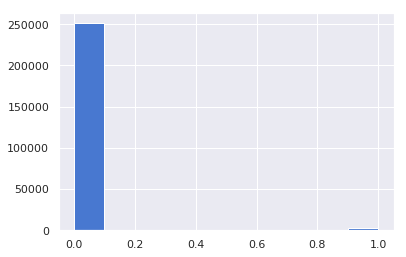

In [59]:
plt.hist(train_df.target);

In [36]:
train_df['target'].value_counts(normalize=True)

0    0.990941
1    0.009059
Name: target, dtype: float64

In [37]:
train_df.sort_values(by='time1', inplace=True)
train_df.drop('session_id', axis=1, inplace=True)
y_train = train_df.pop('target')
test_sessions = test_df.pop('session_id')

train_df.shape, test_df.shape

((253561, 20), (82797, 20))

In [38]:
logit = LogisticRegression(C=1., solver='liblinear', random_state=SEED)
time_cv_split = TimeSeriesSplit(n_splits=10)

In [39]:
def cross_val_scheme(model, X_train, y_train, cv_split, site_features, extra_features=None):
    cv_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv_split, n_jobs=-1)
    print(f'CV Scores \n {cv_scores}')
    print(f'Mean cv score: {cv_scores.mean()} \t Std cv score: {cv_scores.std()}')
    model.fit(X_train, y_train)
    
    if extra_features is not None:
        all_features = site_features + extra_features
    else:
        all_features = site_features
    
    display_html(eli5.show_weights(model, feature_names=all_features, top=30))
    if extra_features is not None:
        print(pd.DataFrame({'Feature': extra_features, 'coef': model.coef_.flatten()[-len(extra_features):]}))
        
    return model, cv_scores

In [43]:
def vectorize_sites(train_df, test_df, sites_df, params):
    train_sessions = train_df[sites].fillna(0).astype(np.int32).apply(lambda row: ' '.join(row.astype(np.str)), axis=1)
    test_sessions = test_df[sites].fillna(0).astype(np.int32).apply(lambda row: ' '.join(row.astype(np.str)), axis=1)
    vectorizer = TfidfVectorizer(**params)
    train_sessions = vectorizer.fit_transform(train_sessions)
    test_sessions = vectorizer.transform(test_sessions)
    
    return vectorizer, train_sessions, test_sessions

In [44]:
%%time

params = {'max_features': 50, 'ngram_range': (1, 1), 'tokenizer': lambda s: s.split()}
vectorizer, train_data, test_data = vectorize_sites(train_df, test_df, sites_df, params)
site_features = vectorizer.get_feature_names()

CPU times: user 57.3 s, sys: 456 ms, total: 57.7 s
Wall time: 58 s


In [45]:
model1, cv_scores1 = cross_val_scheme(logit, train_data, y_train, time_cv_split, site_features)

CV Scores 
 [0.75887802 0.57569307 0.7164359  0.69751096 0.73159674 0.80899742
 0.75491275 0.84128737 0.81594102 0.83037627]
Mean cv score: 0.7531629518002394 	 Std cv score: 0.0756497112210976


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +2.389
 
 
 77
 
 
 
 
 
 
 +2.365
 
 
 81
 
 
 
 
 
 
 +2.046
 
 
 879
 
 
 
 
 
 
 +1.916
 
 
 82
 
 
 
 
 
 
 +1.703
 
 
 270
 
 
 
 
 
 
 +1.504
 
 
 76
 
 
 
 
 
 
 +1.075
 
 
 29
 
 
 
 
 
 
 +1.042
 
 
 941
 
 
 
 
 
 
 +0.999
 
 
 733
 
 
 
 
 
 
 
 … 16 more positive … 
 
 
 

 
 
 
 … 5 more negative … 
 
 
 
 
 
 
 -0.984
 
 
 177
 
 
 
 
 
 
 -1.069
 
 
 178
 
 
 
 
 
 
 -1.171
 
 
 0
 
 
 
 
 
 
 -1.234
 
 
 676
 
 
 
 
 
 
 -1.268
 
 
 814
 
 
 
 
 
 
 -1.574
 
 
 3290
 
 
 
 
 
 
 -1.623
 
 
 953
 
 
 
 
 
 
 -1.904
 
 
 786
 
 
 
 
 
 
 -1.916
 
 
 363
 
 
 
 
 
 
 -2.144
 
 
 167
 
 
 
 
 
 
 -2.179
 
 
 780
 
 
 
 
 
 
 -2.213
 
 
 778
 
 
 
 
 
 
 -2.255
 
 
 1980
 
 
 
 
 
 
 -2.271
 
 
 56
 
 
 
 
 
 
 -2.319
 
 
 747
 
 
 
 
 
 
 -2.983
 
 
 55
 
 
 
 
 
 
 -3.016
 
 
 48
 
 
 
 
 
 
 -3.035
 
 
 782
 
 
 
 
 
 
 -4.024
 
 
 812
 
 
 
 
 
 
 -5.026
 
 
 <BIAS>
 
 
 
 
 
 
 -5.525
 
 
 570

In [22]:
train_num_sites = train_df[sites].count(axis=1)
test_num_sites = test_df[sites].count(axis=1)

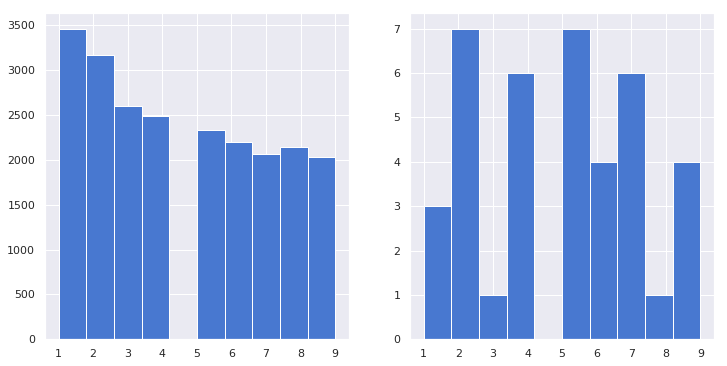

In [24]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
train_num_sites[(train_num_sites < 10) & (y_train == 0)].hist(ax=ax[0])
train_num_sites[(train_num_sites < 10) & (y_train == 1)].hist(ax=ax[1]);

In [25]:
%%time

train_data2 = hstack([train_data, num_train_sites.values.reshape(-1, 1)/10]).tocsr()
test_data2 = hstack([test_data, num_test_sites.values.reshape(-1, 1)/10]).tocsr()
model2, cv_scores2 = cross_val_scheme(logit, train_data2, y_train, time_cv_split, site_features, extra_features=['num_sites'])

NameError: name 'train_data' is not defined

In [66]:
train_nunique_sites = train_df[sites].nunique(axis=1)
test_nunique_sites = test_df[sites].nunique(axis=1)

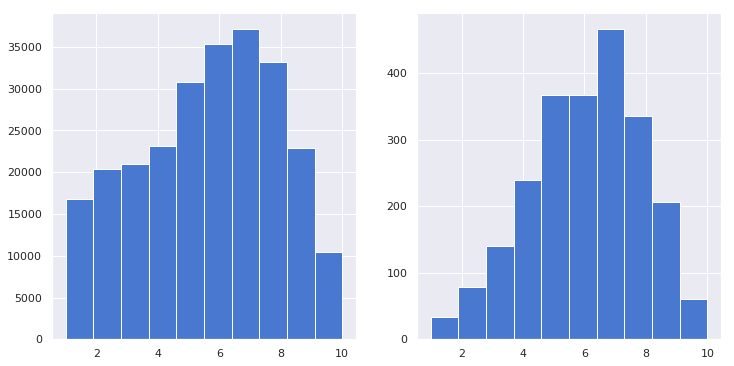

In [61]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
nunique_train_sites[y_train == 0].hist(ax=ax[0])
nunique_train_sites[y_train == 1].hist(ax=ax[1]);

In [62]:
%%time

train_data3 = hstack([train_data, nunique_train_sites.values.reshape(-1, 1)/10]).tocsr()
test_data3 = hstack([test_data, nunique_test_sites.values.reshape(-1, 1)/10]).tocsr()
model3, cv_scores3 = cross_val_scheme(logit, train_data3, y_train, time_cv_split, site_features, extra_features=['nunique_sites'])

CV Scores 
 [0.82947146 0.65873071 0.85453185 0.92829664 0.84880321 0.88892272
 0.88823659 0.8773866  0.92022966 0.92581604]
Mean cv score: 0.8620425479634471 	 Std cv score: 0.07490980135780323


Weight?,Feature
+5.888,youwatch.org
+5.383,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.223,fr.glee.wikia.com
+5.118,vk.com
+4.866,www.info-jeunes.net
+4.496,www.banque-chalus.fr
+4.222,www.express.co.uk
+4.160,www.audienceinsights.net
+4.094,www.melty.fr
+4.003,glee.hypnoweb.net


         Feature     coef
0  nunique_sites -0.07936
CPU times: user 2.63 s, sys: 87.4 ms, total: 2.72 s
Wall time: 8.34 s


In [64]:
top_alice_sites = pd.Series(train_df.loc[y_train == 1, sites].values.flatten()).value_counts(ascending=False)
top_alice_sites = pd.Series(top_alice_sites.index.values, index=top_alice_sites).head(20).reset_index(drop=True) #transpose
top_alice_sites.head()

0    77.0
1    80.0
2    76.0
3    29.0
4    21.0
dtype: float64

In [68]:
train_num_alice_sites = train_df[sites].apply(
    lambda sites: sum([c for site, c in Counter(sites.values).items() if site in top_alice_sites.values]), axis=1)
train_avg_alice_sites = train_num_alice_sites / train_num_sites

test_num_alice_sites = test_df[sites].apply(
    lambda sites: sum([c for site, c in Counter(sites.values).items() if site in top_alice_sites.values]), axis=1)
test_avg_alice_sites = test_num_alice_sites / test_num_sites

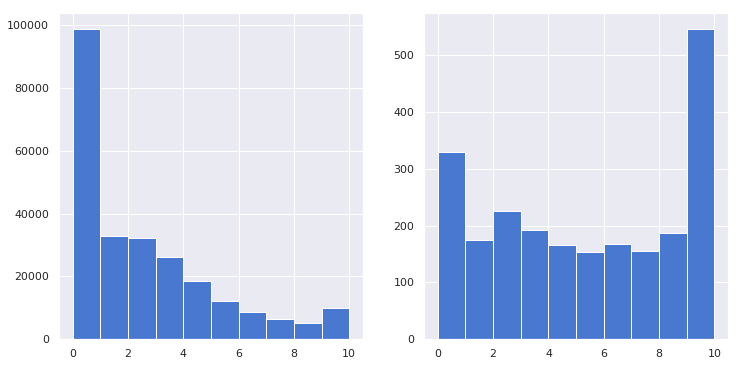

In [69]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
train_num_alice_sites[y_train == 0].hist(ax=ax[0])
train_num_alice_sites[y_train == 1].hist(ax=ax[1]);

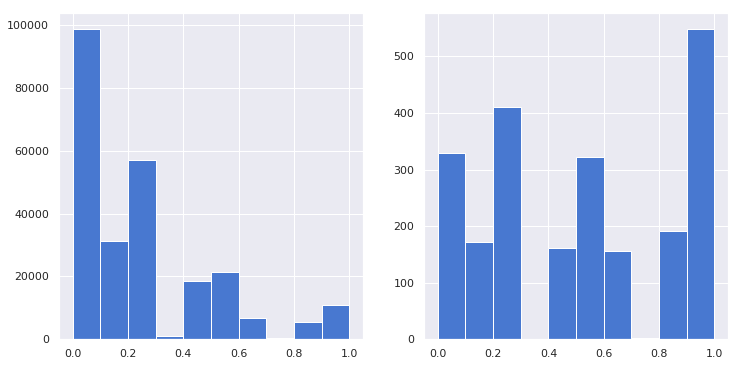

In [70]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
train_avg_alice_sites[y_train == 0].hist(ax=ax[0])
train_avg_alice_sites[y_train == 1].hist(ax=ax[1]);

In [78]:
%%time

train_data4 = hstack([train_data, train_num_alice_sites.values.reshape(-1, 1)/20]).tocsr()
test_data4 = hstack([test_data, test_num_alice_sites.values.reshape(-1, 1)/20]).tocsr()
model4, cv_scores4 = cross_val_scheme(logit, train_data4, y_train, time_cv_split, site_features, extra_features=['num_alice_sites'])

CV Scores 
 [0.83596099 0.67452299 0.85020183 0.92878077 0.83090306 0.88373028
 0.88822372 0.87805647 0.92092123 0.92403489]
Mean cv score: 0.8615336230506541 	 Std cv score: 0.07080050085671248


Weight?,Feature
+5.970,youwatch.org
+5.400,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.336,fr.glee.wikia.com
+4.685,www.info-jeunes.net
+4.591,vk.com
+4.472,www.banque-chalus.fr
+4.249,www.audienceinsights.net
+4.247,www.express.co.uk
+4.125,www.melty.fr
+4.070,media-1.melty.fr


           Feature      coef
0  num_alice_sites  3.039378
CPU times: user 2.87 s, sys: 112 ms, total: 2.98 s
Wall time: 8.64 s


In [81]:
cv_scores4>cv_scores1

array([ True,  True, False,  True, False, False, False,  True,  True,
       False])

In [79]:
%%time

train_data5 = hstack([train_data4, train_avg_alice_sites.values.reshape(-1, 1)]).tocsr()
test_data5 = hstack([test_data4, test_avg_alice_sites.values.reshape(-1, 1)]).tocsr()
model5, cv_scores5 = cross_val_scheme(logit, train_data5, y_train, time_cv_split, site_features, extra_features=['num_alice_sites', 'avg_alice_sites'])

CV Scores 
 [0.83037358 0.67794351 0.85229566 0.92678347 0.82711238 0.88296557
 0.88575609 0.87771859 0.91824845 0.92330846]
Mean cv score: 0.8602505757261152 	 Std cv score: 0.06966220644518005


Weight?,Feature
+5.981,youwatch.org
+5.402,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.348,fr.glee.wikia.com
+4.666,www.info-jeunes.net
+4.527,vk.com
+4.470,www.banque-chalus.fr
+4.262,www.audienceinsights.net
+4.251,www.express.co.uk
+4.130,www.melty.fr
+4.079,media-1.melty.fr


           Feature      coef
0  num_alice_sites  0.923685
1  avg_alice_sites  1.220000
CPU times: user 3.03 s, sys: 120 ms, total: 3.15 s
Wall time: 9.02 s


In [82]:
train_sites_len = train_df[sites].apply(
    lambda sites: np.mean([len(sites_df[site]) for site in set(sites.values) if site > 0]), axis=1)
test_sites_len = test_df[sites].apply(
    lambda sites: np.mean([len(sites_df[site]) for site in set(sites.values) if site > 0]), axis=1)

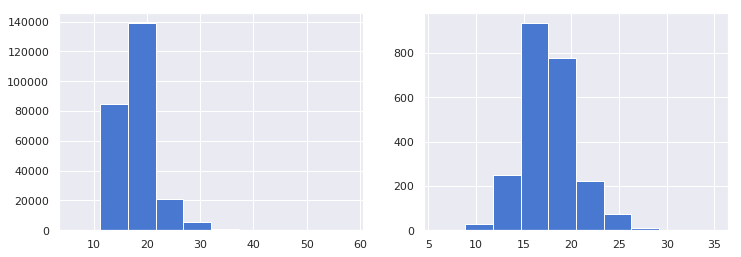

In [85]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train_sites_len[y_train == 0].hist(ax=ax[0])
train_sites_len[y_train == 1].hist(ax=ax[1]);

In [92]:
%%time

train_data6 = hstack([train_data, train_sites_len.values.reshape(-1, 1)]).tocsr()
test_data6 = hstack([test_data, test_sites_len.values.reshape(-1, 1)]).tocsr()
model6, cv_scores6 = cross_val_scheme(logit, train_data6, y_train, time_cv_split, site_features, extra_features=['sites_len'])

CV Scores 
 [0.83281981 0.6695073  0.85769619 0.92622335 0.84219359 0.87347203
 0.8788229  0.87594268 0.91631363 0.92562039]
Mean cv score: 0.8598611880264635 	 Std cv score: 0.07071150784974742


Weight?,Feature
+5.802,youwatch.org
+5.425,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.333,fr.glee.wikia.com
+4.920,vk.com
+4.839,www.info-jeunes.net
+4.486,www.banque-chalus.fr
+4.293,www.audienceinsights.net
+4.234,r4---sn-gxo5uxg-jqbe.googlevideo.com
+4.229,www.express.co.uk
+4.067,r3---sn-gxo5uxg-jqbe.googlevideo.com


     Feature      coef
0  sites_len -0.050813
CPU times: user 3.55 s, sys: 84.5 ms, total: 3.64 s
Wall time: 11.4 s


In [93]:
cv_scores6 > cv_scores1

array([ True,  True,  True, False, False, False, False, False, False,
       False])

In [130]:
train_duration = (train_df[times].max(axis=1) - train_df[times].min(axis=1)).dt.seconds
test_duration = (test_df[times].max(axis=1) - test_df[times].min(axis=1)).dt.seconds

duration_scaler = StandardScaler()
train_duration = duration_scaler.fit_transform(train_duration.values.reshape(-1, 1)).reshape(-1)
test_duration = duration_scaler.transform(test_duration.values.reshape(-1, 1)).reshape(-1)

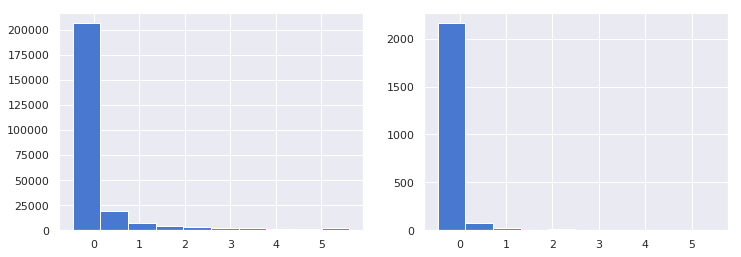

In [131]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(train_duration[y_train == 0])
ax[1].hist(train_duration[y_train == 1]);

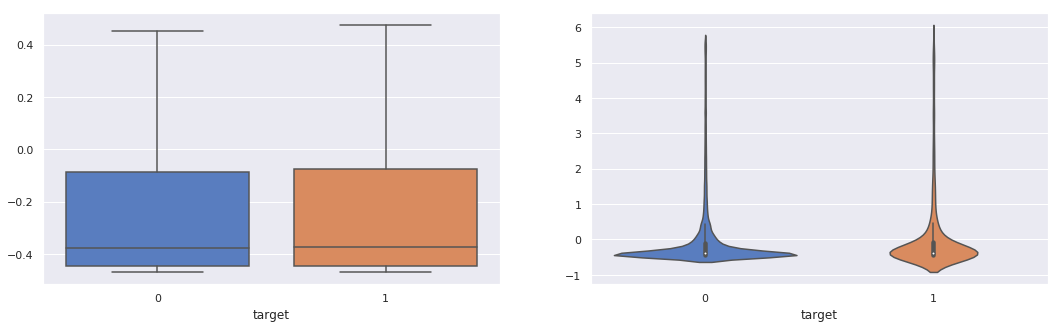

In [132]:
_, ax = plt.subplots(1, 2, figsize=(18, 5))

sns.boxplot(y_train, train_duration, showfliers=False, ax=ax[0])
sns.violinplot(y_train, train_duration, showfliers=False, ax=ax[1]);

In [136]:
cv_scores7 > cv_scores1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [134]:
%%time

train_data7 = hstack([train_data, train_duration.reshape(-1, 1)]).tocsr()
test_data7 = hstack([test_data, test_duration.reshape(-1, 1)]).tocsr()
model7, cv_scores7 = cross_val_scheme(logit, train_data7, y_train, time_cv_split, site_features, extra_features=['sites_len'])

CV Scores 
 [0.81304837 0.66460851 0.85974324 0.92860058 0.84842408 0.89343837
 0.8922839  0.87964365 0.92343743 0.92674302]
Mean cv score: 0.86299711602618 	 Std cv score: 0.07493847885981136


Weight?,Feature
+5.874,youwatch.org
+5.352,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.200,fr.glee.wikia.com
+5.151,vk.com
+4.859,www.info-jeunes.net
+4.540,www.banque-chalus.fr
+4.210,www.express.co.uk
+4.113,www.audienceinsights.net
+4.068,www.melty.fr
+4.003,media-1.melty.fr


     Feature      coef
0  sites_len -0.232716
CPU times: user 2.73 s, sys: 64.7 ms, total: 2.8 s
Wall time: 8.86 s


In [324]:
def add_time_features(df):
    time_data = []
    time_features = []
    
    duration = (df[times].max(axis=1) - df[times].min(axis=1)).dt.seconds
    nunique_sites = df[sites].nunique(axis=1)
    avg_duration = (duration / nunique_sites).values.reshape(-1, 1)
    avg_duration_scaler = StandardScaler()
    avg_duration = avg_duration_scaler.fit_transform(avg_duration)
    time_data.append(avg_duration)
    time_features.append('avg_duration')
    
    start_month = df['time1'].dt.month.values.reshape(-1, 1)
#     time_data.append(start_month)
#     time_features.append('start_month')
    
    year_month = df['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    time_data.append(year_month)
    time_features.append('year_month')

    start_year = df['time1'].dt.year
    start_year = pd.get_dummies(start_year, drop_first=True).values.reshape(-1, 1)
#     time_data.append(start_year)
#     time_features.append('start_year')
    
    start_weekday = df['time1'].dt.dayofweek.values.reshape(-1, 1)
    time_data.append(start_weekday/7)
    time_features.append('start_weekday')
    
    start_weekend = (start_weekday > 0.4).astype(np.int16).reshape(-1, 1)
#     time_data.append(start_weekend)
#     time_features.append('start_weekend')
    
    start_hour = (df['time1'].dt.hour).astype(np.int32)
    start_hour[start_hour == 24] = 0
    start_hour = start_hour.values.reshape(-1, 1)
#     time_data.append(start_hour)
#     time_features.append('start_hour')
    
    morning = ((start_hour >= 7) & (start_hour <= 11)).astype(np.int16).reshape(-1, 1)
    time_data.append(morning)
    time_features.append('morning')
    
    day = ((start_hour >= 12) & (start_hour <= 18)).astype(np.int16).reshape(-1, 1)
    time_data.append(day)
    time_features.append('day')
    
    evening = ((start_hour >= 19) & (start_hour <= 23)).astype(np.int16).reshape(-1, 1)
    time_data.append(evening)
    time_features.append('evening')
    
    night = ((start_hour >= 0) & (start_hour <= 6)).astype(np.int16).reshape(-1, 1)
#     time_data.append(night)
#     time_features.append('night')
    
    
    return time_data, time_features 

In [325]:
train_time_data, time_features = add_time_features(train_df)
extra_features = ['duration'] + time_features

In [326]:
test_time_data, _ = add_time_features(test_df)
# for a in test_time_data:
#     print(a.shape)

In [327]:
%%time
"""
CV Scores 
 [0.84195876 0.81265465 0.91787787 0.96410924 0.91657807 0.96028059
 0.92680102 0.95347576 0.95794296 0.96980186]
Mean cv score: 0.9221480791325313 	 Std cv score: 0.05122348502762396

CV Scores 
 [0.8439107  0.81429192 0.91821458 0.96207937 0.91579467 0.95636962
 0.928289   0.94874012 0.95771316 0.96733218]
Mean cv score: 0.9212735321241597 	 Std cv score: 0.04961771623648139
"""
train_data8 = hstack([train_data7] + train_time_data).tocsr()
test_data8 = hstack([test_data7] + test_time_data).tocsr()
model7, cv_scores7 = cross_val_scheme(logit, train_data8, y_train, time_cv_split, site_features, extra_features=extra_features)

CV Scores 
 [0.8439107  0.81429192 0.91821458 0.96207937 0.91579467 0.95636962
 0.928289   0.94874012 0.95771316 0.96733218]
Mean cv score: 0.9212735321241597 	 Std cv score: 0.04961771623648139


Weight?,Feature
+5.007,www.express.co.uk
+4.940,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.862,youwatch.org
+4.835,vk.com
+4.465,www.info-jeunes.net
+4.368,www.melty.fr
+4.228,fr.glee.wikia.com
+4.069,www.audienceinsights.net
+4.065,www.banque-chalus.fr
+3.930,r4---sn-gxo5uxg-jqbe.googlevideo.com


         Feature      coef
0       duration -0.314237
1   avg_duration  0.067474
2     year_month -2.627411
3  start_weekday -2.226662
4        morning -1.654429
5            day  2.104830
6        evening -1.600411
CPU times: user 4.45 s, sys: 159 ms, total: 4.6 s
Wall time: 15.4 s


In [328]:
def create_submission(test_preds, session_ids, name='submission'):
    df = pd.DataFrame({'session_id': session_ids, 'target': test_preds})
    df.to_csv(f'{name}.csv', header=True, index=False)
    return df

In [332]:
test_preds = model7.predict_proba(test_data8)[:, 1]
test_final = create_submission(test_preds, test_sessions)

In [ ]:
params = {
    'C': np.logspace(-2, 2, 20),
    'class_weight': [None, 'balanced'],
    'solver': ['sag', 'liblinear']
}

grid_search = GridSearchCV(estimator=logit, param_grid=params,
                                  scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)
grid_search.fit(train_data8, y_train)

In [ ]:
final_model = grid_search.best_estimator_
grid_search.best_score, grid_search.best_params_

In [ ]:
final_test_preds = final_model.predict_proba(test_data8)[:, 1]
test_final = create_submission(final_test_preds, test_sessions, name='final_submission')